# Code 1

## Import Main Libraries

In [1]:
import numpy as np      
import pandas as pd     
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from keras.preprocessing import image
from sklearn import metrics

tf.keras.backend.clear_session()

2025-04-19 01:16:34.633311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745025394.833120      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745025394.890960      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Loading and Directory Setup

In [2]:
# Define the main path of the dataset
main_path = '/kaggle/input/main-dataset/ND'

# Define the directories for training, validation, and testing
train_dir = os.path.join(main_path, 'train')
valid_dir = os.path.join(main_path, 'val')
test_dir  = os.path.join(main_path, 'test')

# Function to list image paths recursively in a given folder.
def list_images(directory, ext='*.jpg'):
    # This will list all images matching the pattern recursively
    return glob.glob(os.path.join(directory, '**', ext), recursive=True)

# Example: List images from the 'fake' and 'real' subfolders in the test set
test_fake_path = os.path.join(test_dir, 'fake')
test_real_path = os.path.join(test_dir, 'real')

# Optional: Verify the immediate subfolder names for each set
print("\nImmediate subfolders in train:")
print(os.listdir(train_dir))
print("\nImmediate subfolders in valid:")
print(os.listdir(valid_dir))
print("\nImmediate subfolders in test:")
print(os.listdir(test_dir))


Immediate subfolders in train:
['fake', 'real']

Immediate subfolders in valid:
['fake', 'real']

Immediate subfolders in test:
['fake', 'real']


## Exploratory Data Analysis (EDA)

In [3]:
# Initialize dictionary to collect image metadata
images_df = {
    "folder": [],      # This will store train/valid/test
    "image_path": [],  # Full path to image
    "label": []        # Label (e.g., real/fake)
}

# Iterate over each dataset split: train, valid, and test
for folder in os.listdir(main_path):
    split_path = os.path.join(main_path, folder)
    # Check if the path is a directory
    if os.path.isdir(split_path):
        # Iterate over each label folder: fake, real, etc.
        for label in os.listdir(split_path):
            label_path = os.path.join(split_path, label)
            if os.path.isdir(label_path):
                # Use glob to recursively find all .jpg files inside the label folder
                image_files = glob.glob(os.path.join(label_path, '**', '*.jpg'), recursive=True)
                for img_path in image_files:
                    images_df["folder"].append(folder)
                    images_df["image_path"].append(img_path)
                    images_df["label"].append(label)

# Create the dataframe using pandas
images_df = pd.DataFrame(images_df)

## Labels Distribution

In [4]:
# Group images by folder for each label to check distribution
real_grouped_df = images_df[images_df['label'] == "real"].groupby('folder')
fake_grouped_df = images_df[images_df['label'] == "fake"].groupby('folder')

print("Real Images Count:\n", real_grouped_df.size())
print("Fake Images Count:\n", fake_grouped_df.size())

Real Images Count:
 Series([], dtype: int64)
Fake Images Count:
 Series([], dtype: int64)


## Data Augmentation Setup

In [5]:
# Set up ImageDataGenerators for training (with augmentation) and for validation/testing (rescaling only)
image_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip=True
)

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

## Data Flow Setup for Training, Validation, and Testing

In [6]:
# Create training, validation, and test datasets using flow_from_directory
train_ds = image_train_gen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary'
)

valid_ds = image_gen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary'
)

# For test data, disable shuffling to keep predictions aligned with ground truth
test_ds = image_gen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

Found 119254 images belonging to 2 classes.
Found 34024 images belonging to 2 classes.
Found 17082 images belonging to 2 classes.


## Helper Function for Visualizing Images

In [7]:
def plot_images(img, label):
    plt.figure(figsize=[12, 12])
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(img[i])
        plt.axis('off')
        plt.title("Fake" if label[i] == 0 else "Real")

## Visualize a Batch of Training Images

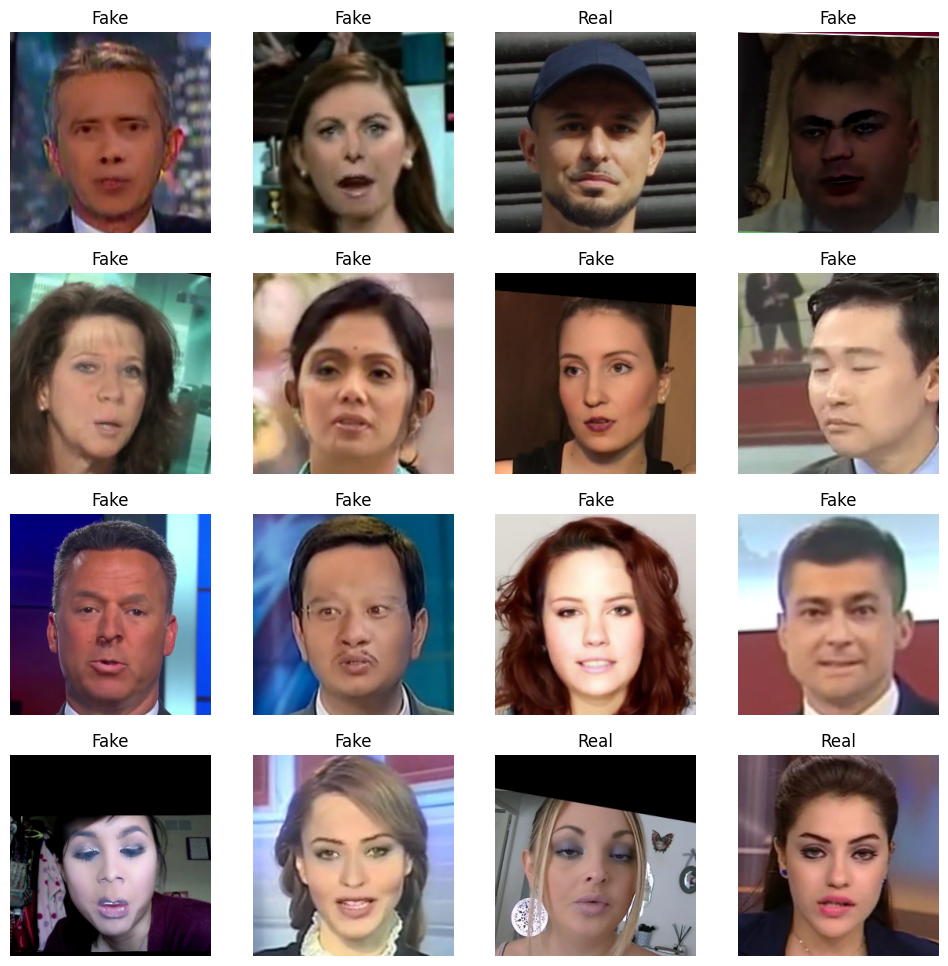

In [8]:
# Get a batch from the training set and visualize
img_batch, lbl_batch = next(train_ds)
plot_images(img_batch, lbl_batch)

## Check Image Scaling and Input Shape

In [9]:
# Check the scaled pixel values
for img, label in train_ds:
    print("Example image values:", img[0])
    print("Example label:", label[0])
    break

# Check the shape of a batch
for img, label in train_ds:
    print("Image batch shape:", img.shape)  # Expected: (batch_size, 256, 256, 3)
    print("Label batch shape:", label.shape)
    break

# Display class indices (mapping labels to numeric values)
print("Class indices:", train_ds.class_indices)

Example image values: [[[0.16078432 0.14509805 0.47058827]
  [0.16078432 0.14509805 0.47058827]
  [0.16078432 0.14509805 0.47450984]
  ...
  [0.25882354 0.3803922  1.        ]
  [0.25882354 0.3803922  1.        ]
  [0.25882354 0.3803922  1.        ]]

 [[0.16078432 0.14509805 0.47058827]
  [0.16078432 0.14509805 0.47450984]
  [0.16078432 0.14509805 0.47450984]
  ...
  [0.25882354 0.3803922  1.        ]
  [0.25882354 0.3803922  1.        ]
  [0.25882354 0.3803922  1.        ]]

 [[0.16078432 0.14117648 0.47058827]
  [0.16078432 0.14117648 0.4784314 ]
  [0.16078432 0.14117648 0.4784314 ]
  ...
  [0.25882354 0.3803922  1.        ]
  [0.25882354 0.3803922  1.        ]
  [0.25882354 0.3803922  1.        ]]

 ...

 [[0.654902   0.34509805 0.23529413]
  [0.6313726  0.34509805 0.227451  ]
  [0.62352943 0.34117648 0.21960786]
  ...
  [0.31764707 0.3019608  0.7411765 ]
  [0.3137255  0.29803923 0.73333335]
  [0.3137255  0.3019608  0.7294118 ]]

 [[0.6509804  0.34117648 0.23137257]
  [0.627451   0

## Build the CNN Model Using DenseNet121

In [10]:
# Define input shape
input_shape = (256, 256, 3)

# Build the model using DenseNet121 as the backbone
def get_model(input_shape):
    inp = tf.keras.Input(shape=input_shape)
    densenet = tf.keras.applications.DenseNet121(weights="imagenet", include_top=False, input_tensor=inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(densenet.output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Binary classification
    model = tf.keras.Model(densenet.input, output)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

model_ft = get_model(input_shape)
model_ft.summary()
# tf.keras.utils.plot_model(model_ft, show_shapes=True)

I0000 00:00:1745025882.247222      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 64, 64, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 64, 64, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 64, 64, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 7,564,865 (28.86 MB)

 Trainable params: 7,480,193 (28.53 MB)

 Non-trainable params: 84,672 (330.75 KB)

## Define Training Callbacks

In [11]:
# Set up callbacks to save the best model and adjust training as necessary
checkpoint_filepath = "model_cp.weights.h5"
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3
)

## Train the DenseNet121 Model

In [12]:
# Train the model with the training and validation datasets
history_ft = model_ft.fit(
    train_ds,
    epochs=20,
    validation_data=valid_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745026002.768058     117 service.cc:148] XLA service 0x7fd324004b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745026002.768710     117 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745026011.177841     117 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745026090.903747     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1864/1864 ━━━━━━━━━━━━━━━━━━━━ 1623s 775ms/step - accuracy: 0.8150 - loss: 0.4317 - val_accuracy: 0.6795 - val_loss: 1.4127 - learning_rate: 0.0010
Epoch 2/20
1864/1864 ━━━━━━━━━━━━━━━━━━━━ 925s 495ms/step - accuracy: 0.9464 - loss: 0.1354 - val_accuracy: 0.8276 - val_loss: 0.5902 - learning_rate: 0.0010
Epoch 3/20
1864/1864 ━━━━━━━━━━━━━━━━━━━━ 942s 504ms/step - accuracy: 0.9661 - loss: 0.0896 - val_accuracy: 0.9206 - val_loss: 0.2035 - learning_rate: 0.0010
Epoch 4/20
1864/1864 ━━━━━━━━━━━━━━━━━━━━ 967s 517ms/step - accuracy: 0.9721 - loss: 0.0754 - val_accuracy: 0.8088 - val_loss: 0.5348 - learning_rate: 0.0010
Epoch 5/20
1864/1864 ━━━━━━━━━━━━━━━━━━━━ 957s 512ms/step - accuracy: 0.9797 - loss: 0.0575 - val_accuracy: 0.8674 - val_loss: 0.3528 - learning_rate: 0.0010
Epoch 6/20
1864/1864 ━━━━━━━━━━━━━━━━━━━━ 954s 511ms/step - accuracy: 0.9821 - loss: 0.0490 - val_accuracy: 0.9070 - val_loss: 0.2672 - learning_rate: 0.0010
Epoch 7/20
1864/1864 ━━━━━━━━━━━━━━━━━━━━ 1004s 537ms/step - a

## Plot Training History

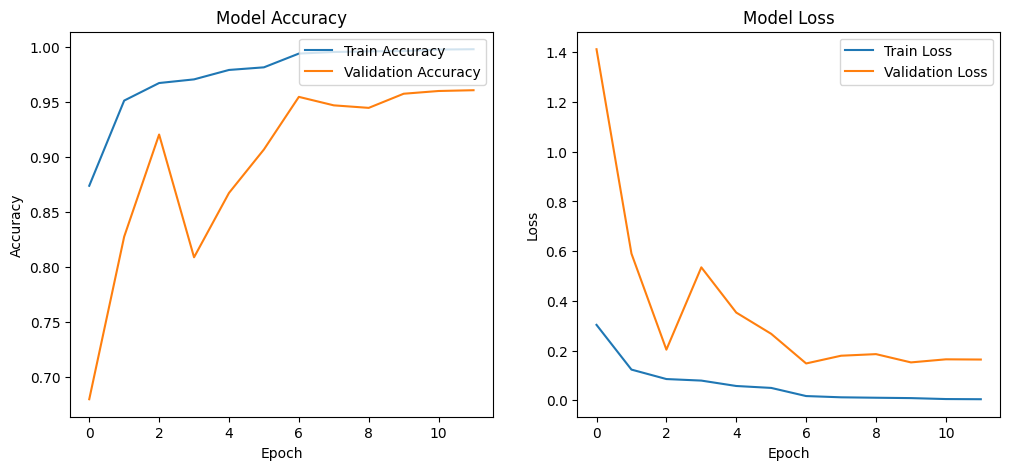

In [13]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_ft.history['accuracy'], label='Train Accuracy')
plt.plot(history_ft.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_ft.history['loss'], label='Train Loss')
plt.plot(history_ft.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

## Evaluate the Model on the Test Set (Before Restoration)

In [14]:
# Evaluate the model (which may be overfitted) on the test set
test_loss, test_acc = model_ft.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

267/267 ━━━━━━━━━━━━━━━━━━━━ 200s 752ms/step - accuracy: 0.9403 - loss: 0.1853
Test Loss: 0.19370418787002563
Test Accuracy: 0.9399367570877075


## Restore Best Weights and Re-Evaluate

In [15]:
# Create a new model instance and load the best weights saved during training
model = get_model(input_shape)
model.load_weights('/kaggle/working/model_cp.weights.h5')  # Adjust the path as necessary

# Evaluate the restored model on the test set
test_loss, test_acc = model.evaluate(test_ds)
print("Test Loss after restoring best weights:", test_loss)
print("Test Accuracy after restoring best weights:", test_acc)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 738 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


267/267 ━━━━━━━━━━━━━━━━━━━━ 105s 337ms/step - accuracy: 0.9403 - loss: 0.1853
Test Loss after restoring best weights: 0.19370418787002563
Test Accuracy after restoring best weights: 0.9399367570877075


## Qualitative Results: Real Image Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


Text(0.5, 1.0, 'This image is 0.00% Fake and 100.00% Real.')

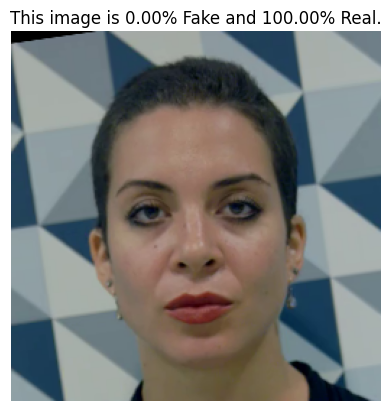

In [16]:
# Load a real image example and predict
test_image = tf.keras.preprocessing.image.load_img(
    '/kaggle/input/main-dataset/ND/test/real/actors_01__talking_against_wall/000.png',
    target_size=(256, 256, 3)
)
plt.imshow(test_image)
plt.axis('off')

test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image_arr, axis=0)
test_image_arr = test_image_arr / 255.

result = model.predict(test_image_arr)
plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")


## Qualitative Results: Fake Image Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Text(0.5, 1.0, 'This image is 99.99% Fake and 0.01% Real.')

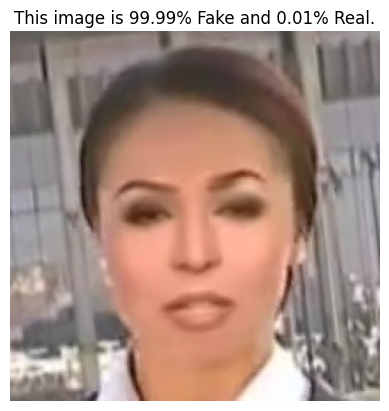

In [17]:
# Load a fake image example and predict
test_image = tf.keras.preprocessing.image.load_img(
    '/kaggle/input/main-dataset/ND/test/fake/df_007_132/000.png',
    target_size=(256, 256, 3)
)
plt.imshow(test_image)
plt.axis('off')

test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image_arr, axis=0)
test_image_arr = test_image_arr / 255.

result = model.predict(test_image_arr)
plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

## Quantitative Results: Confusion Matrix and ROC Curve

267/267 ━━━━━━━━━━━━━━━━━━━━ 105s 351ms/step


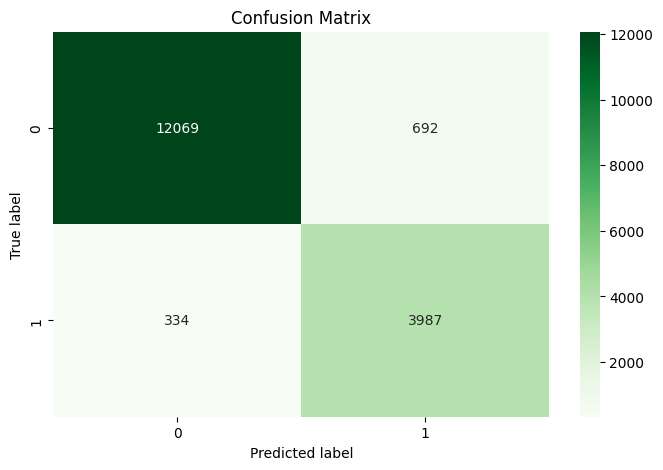

Test Accuracy: 0.9399


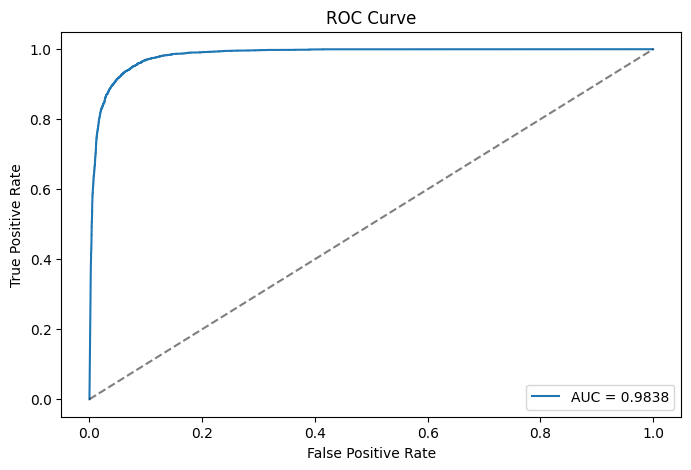

Precision: 0.8521
Recall:    0.9227
F1 Score:  0.8860

Classification Report:
              precision    recall  f1-score   support

           0     0.9731    0.9458    0.9592     12761
           1     0.8521    0.9227    0.8860      4321

    accuracy                         0.9399     17082
   macro avg     0.9126    0.9342    0.9226     17082
weighted avg     0.9425    0.9399    0.9407     17082



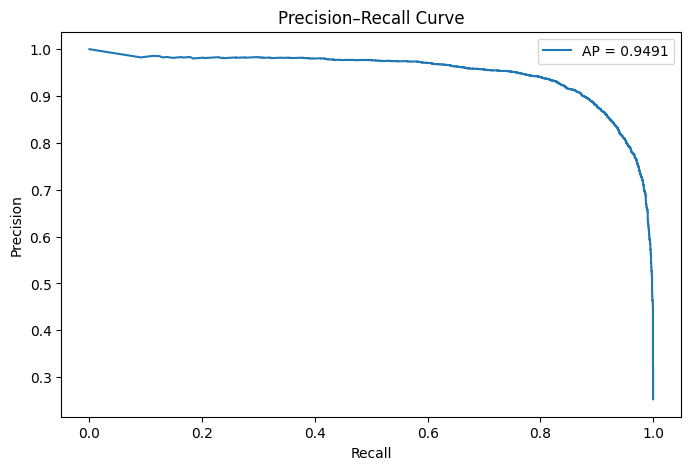

In [18]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Generate predictions for the test set
predicted_proba = model.predict(test_ds)
predicted_labels = predicted_proba.round()
true_labels = test_ds.classes

# Confusion Matrix & Accuracy
plt.figure(figsize=(8, 5))
sns.heatmap(
    metrics.confusion_matrix(true_labels, predicted_labels),
    annot=True, fmt="d", cmap="Greens"
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

acc = metrics.accuracy_score(true_labels, predicted_labels)
print(f"Test Accuracy: {acc:.4f}")

# ROC Curve & AUC
fpr, tpr, _ = metrics.roc_curve(true_labels, predicted_proba)
auc = metrics.roc_auc_score(true_labels, predicted_proba)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Precision, Recall, F1-score
precision = metrics.precision_score(true_labels, predicted_labels)
recall    = metrics.recall_score(true_labels, predicted_labels)
f1        = metrics.f1_score(true_labels, predicted_labels)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}\n")

# Full classification report (includes support, per-class metrics)
print("Classification Report:")
print(metrics.classification_report(true_labels, predicted_labels, digits=4))

# Precision-Recall Curve & Average Precision
pr_precision, pr_recall, pr_thresholds = metrics.precision_recall_curve(
    true_labels, predicted_proba
)
avg_precision = metrics.average_precision_score(true_labels, predicted_proba)

plt.figure(figsize=(8, 5))
plt.plot(pr_recall, pr_precision, label=f"AP = {avg_precision:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend(loc="upper right")
plt.show()

## Save Final Model

In [19]:
# Save the final trained model to disk
model.save('deepfake_detection_model.h5')
print("Final model saved successfully!")

Final model saved successfully!
